In [1]:
from functools import partial

import diffrax as dfx
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from dynamical_systems.continuous import AbstractODE, Lorenz63, solve_ode, TangentODE
from dynamical_systems.dataset import TimeSeriesDataset
from dynamical_systems.linalg import gram_schmidt
from dynamical_systems.metrics import lyapunov_gr
from dynamics_discovery.models import NeuralODE
from jaxtyping import Array, Float
from matplotlib_utils.axes_setters import set_labels


jax.config.update("jax_enable_x64", True)

In [2]:
dataset_loaded = TimeSeriesDataset.load("./data/lorenz.hdf5")
u_train = dataset_loaded.u[0]

In [3]:
dataset_loaded.t.shape

(100000,)

In [4]:
key = 0
model = NeuralODE(3, 32, 3, key=key)

In [5]:
t_sample = dataset_loaded.t[0:1000]
u_sample = u_train[0:1000]
lya_local, sol = lyapunov_gr(model, u_sample[0], t_sample)


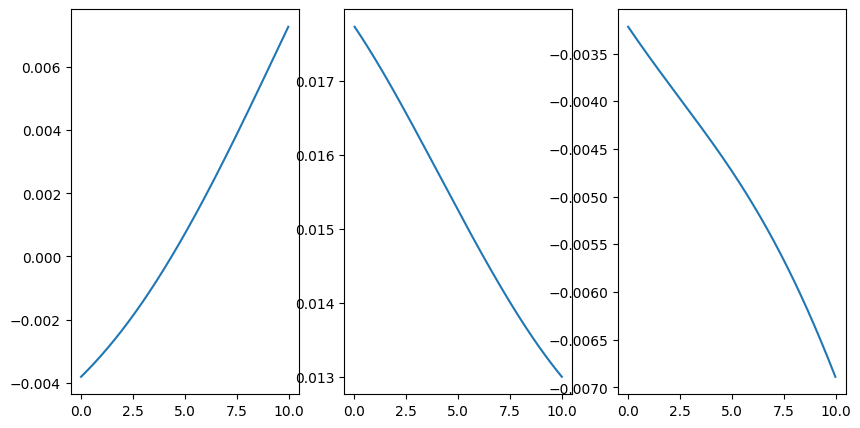

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for i, ax in enumerate(axes):
    ax.plot(t_sample, lya_local[i])

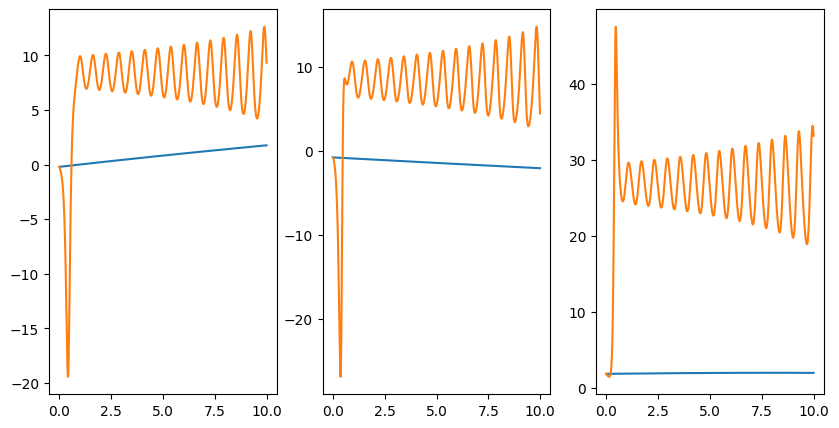

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for i, ax in enumerate(axes):
    ax.plot(t_sample, sol.T[i])
    ax.plot(t_sample, u_sample.T[i])